## Install packages

In [1]:
### install my package
### pip install git+git://github.com/chvlyl/kernel_kmeans_and_adaptive_clustering.git
### re-install the package if it is updated
### pip install --upgrade git+git://github.com/chvlyl/kernel_kmeans_and_adaptive_clustering.git

In [2]:
import sys
import pandas as pd
import numpy as np
#from kmean_clustering import kmean_clustering as kc

In [3]:
print('Python')
print(sys.version)
print('Numpy')
print(np.__version__)
print('Pandas')
print(pd.__version__)

Python
3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 13:51:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Numpy
1.13.3
Pandas
0.20.3


## Functions

In [9]:
def plot_weight_matrix(weight_matrix):
    plt.imshow(weight_matrix)
    plt.show()

In [16]:
from  scipy.spatial.distance import pdist,squareform

def k_means(data, n_clusters=3, n_init=20, max_iter=100, kernel=None,verbose=False):
    '''
    data: a numeric numpy array
    n_clusters: number of clusters
    n_init: number of different initializations to run kmeans
    max_iter: number of max iterations 
    verbose: output detailed information
    kernel: "None", regular k means; "gaussian",  k means with gaussian kernel
    '''
    ### may not be efficient in terms of memory use
    ### no need to save whole history
    ### get whole hitory for debugging purpose
    controid_history = {}
    cluster_label_history = {}
    sse_history = np.zeros(shape=(n_init,1))
    ### start k-means
    n_points = data.shape[0]
    ### calculate the kernel matrix
    if kernel == 'gaussian':
        sigma = 1.0
        ### 'sqeuclidean': squared Euclidean distance
        kernel_matrix = np.exp(-0.5/(sigma**2)*squareform(pdist(data,'sqeuclidean')))
    ### repeat k-means n_init times 
    ### return the best one 
    for i_init in range(n_init):
        if verbose: print('Random seed',i_init)
        #### set random seed
        np.random.seed(i_init)
        #### generate initial cluster labels
        cluster_labels = np.random.choice(range(n_clusters),size=n_points, replace=True)
        #### generate initial centroids
        #### randomly choose n_clusters points from the data as centroids
        centroids = data[np.random.choice(np.arange(n_points), n_clusters, replace=False),:]
        for i_iter in range(max_iter):
            if verbose: print('Iteration',i_iter,end=', ')
            distance_to_centroids = np.zeros(shape=(data.shape[0],n_clusters))
            for i_centroid in range(n_clusters):
                if kernel is None:
                    ### ord=2 is L2 distance
                    ### axis=1 is to calculate norm along columns
                    distance_to_centroids[:,i_centroid] = np.linalg.norm(data-centroids[i_centroid,:],ord=2,axis=1)
                elif kernel == 'gaussian':
                    kth_cluster_ind = (cluster_labels == i_centroid).astype('int')
                    kth_cluster_matrix = np.outer(kth_cluster_ind,kth_cluster_ind)
                    dist1 = np.diag(kernel_matrix)
                    dist2 = 2.0*np.sum(np.tile(kth_cluster_ind,(n_points,1))*kernel_matrix,axis=1)/np.sum(kth_cluster_ind)
                    dist3 = np.sum(kth_cluster_matrix*kernel_matrix)/np.sum(kth_cluster_matrix)
                    #print(dist1.shape,dist2.shape,dist3.shape,)
                    ### ord=2 is L2 distance
                    ### axis=1 is to calculate norm along columns
                    distance_to_centroids[:,i_centroid] = dist1-dist2+dist3
                    #break
                else:
                    sys.exit('Kernel parameter is not correct!')
            #print(distance_to_centroids)
            ### assign the cluster labels
            cluster_labels = np.argmin(distance_to_centroids,axis=1)
            sse = np.sum((np.min(distance_to_centroids,axis=1))**2)
            if verbose: print('SSE',sse)
            ### re-calculate centroids
            previous_centroids = centroids
            centroids = np.array([data[cluster_labels == i_centroid].mean(axis = 0) for i_centroid in range(n_clusters)])
            ### if centroids don't change
            ### stop the iteration
            if np.all(previous_centroids == centroids):
                if verbose: print('Centroids do not change',i_iter)
                break
            #break
        controid_history[i_init] = centroids
        cluster_label_history[i_init] = cluster_labels
        sse_history[i_init] = sse
        #break
    ### find the best initializations
    best_iter = np.argmin(sse_history)
    best_sse = sse_history[best_iter]
    best_controids = controid_history[best_iter]
    best_cluster_label = cluster_label_history[best_iter]
    
    return {'best_iter':best_iter,
            'best_sse':best_sse,
            'best_controids':best_controids,
            'best_cluster_label':best_cluster_label,
            'controid_history':controid_history,
            'cluster_label_history':cluster_label_history,
            'sse_history':sse_history,
           }

In [59]:
import scipy
from scipy.spatial import distance_matrix

def adaptive_cluster(data, gap_par = 0.5, debug=False):
    (n_points,n_features) = data.shape
    distance_matrix = scipy.spatial.distance_matrix(data,data)
    #print('distance_matrix.shape',distance_matrix.shape)
    weight_matrix = np.zeros(shape=(n_points,n_points))
    #print('weight_matrix.shape',weight_matrix.shape)
    #plot_weight_matrix(weight_matrix)
    ### sort the distance matrix
    sorted_distance_idx_matrix = np.argsort(distance_matrix,axis=1)
    sorted_distance_matrix = np.sort(distance_matrix,axis=1)
    #print('sorted_distance_matrix.shape',sorted_distance_matrix.shape)    
    #print('sorted_distance_idx_matrix.shape',sorted_distance_idx_matrix.shape)
    ### number of neighbors
    n0 = 2*n_features+2
    ### h0 is the the radius such that the point has n0 neighbors 
    h0 = sorted_distance_matrix[:,n0]
    #print('h0.shape',h0.shape)
    ### max(h0(Xi),h0(Xj))
    max_h0 = np.reshape([np.maximum(h0[i],h0[j]) for i in range(n_points) for j in range(n_points)],newshape=(n_points,n_points))
    #print('max_h0.shape',max_h0.shape)
    ### weight_matrix
    weight_matrix = (distance_matrix <= max_h0).astype('int')
    #print('weight_matrix.shape',weight_matrix.shape)
    #plot_weight_matrix(weight_matrix)


    #################################################################
    ### find h sequence
    a = 1.4142135623730951
    b = 1.95
    #gap_par = -1 
    max_distance = np.max(sorted_distance_matrix)
    ### h0 is a vector, each data point has n0 neighbors
    ### max(h0) makes sure that each data point has at least n0 neighbors
    h_array  = np.array([np.max(h0)])
    #n_matrix = np.repeat(n0, n_points)
    #n_matrix = n_matrix[:,np.newaxis]
    k = 0

    while h_array[k] <= max_distance:
        ### upper bound of n(Xi,h_k+1)
        ### given radius h_array[k], how many neighbors for each data point
        ### -1 removes its self from counting
        n_upper = a * np.array([np.sum(sorted_distance_matrix[i,:]<=h_array[k])-1 for i in np.arange(n_points)])
        n_upper = (np.floor(n_upper)).astype('int')
        ### when h is big, the n_upper may be > n_points
        n_upper = np.clip(n_upper, a_min=None,a_max=(n_points-1))
        #print(n_upper)
        ### n_upper can decide the h_upper
        h_upper_by_n_upper = np.min(np.array([sorted_distance_matrix[i,n_upper[i]] for i in np.arange(n_points)]))
        ### upper bound of h_k+1
        h_upper = b*h_array[k]
        ### must satisfy both conditions
        min_h_upper = np.minimum(h_upper_by_n_upper,h_upper)
        #print(k,min_h_upper)
        ### append to the h_array
        ### just make sure h is not > max_distance
        if min_h_upper <= max_distance:
            if  min_h_upper <= h_array[k]: break
            #print(k,'h',min_h_upper)
            h_array = np.append(h_array,min_h_upper)
        k = k + 1

    #################################################################    
    ### check if those h satisfy the conditions
    if debug:
        for k in range(1,len(h_array)):  
            if h_array[k] <= b*h_array[k-1]:
                continue
                print('k',k,h_array[k],h_array[k-1],b*h_array[k-1],end=',')
                print(h_array[k]/h_array[k-1])
            else:
                print('h error')
        for k in range(1,len(h_array)):
            for i in range(n_points):
                n1 = np.sum(sorted_distance_matrix[i,:]<=h_array[k-1])-1 
                n2 = np.sum(sorted_distance_matrix[i,:]<=h_array[k])-1 
                if n2<=a*n1 and n1>=n0 and n2>=n0:
                    continue
                    print('n',k,n1,n2,a*n1,end=',')
                    print(n2/n1)
                else:
                    print('n error')
        
    #################################################################
    beta_a = (n_features+1.0)/2.0
    beta_b = 0.5
    beta_function = scipy.special.beta(beta_a,beta_b)

    np.seterr(divide='ignore', invalid='ignore')  

    for k in range(1,len(h_array)):
        #print('h_k',h_array[k])
        distance_matrix_temp = distance_matrix.copy()
        distance_matrix_temp = np.where(distance_matrix_temp <= h_array[k], distance_matrix_temp, np.nan)  
        #weight_matrix = (distance_matrix <= h_array[k]).astype('int')
        #plot_weight_matrix(weight_matrix)
        #### caclulate overlap
        ### repalce l=i,j elements  to 0
        ### no need to consider l!=i,j elements in the following calculation
        np.fill_diagonal(weight_matrix,0) 
        N_overlap = [np.dot(weight_matrix[i,:],weight_matrix[j,:]) for i in range(n_points) for j in range(n_points)]
        N_overlap = np.reshape(N_overlap,newshape=(n_points,n_points))
        #### caclulate complement
        N_complement = np.zeros(shape=(n_points,n_points))
        for i in range(n_points):
            for j in range(n_points):
                if k>1:
                    ind1 = (distance_matrix[j,:] > h_array[k-1]).astype('int')
                    ind2 = (distance_matrix[i,:] > h_array[k-1]).astype('int')
                if k==1:
                    ind1 = (distance_matrix[j,:] > np.maximum(h0[i],h0[j])).astype('int')
                    ind2 = (distance_matrix[i,:] > np.maximum(h0[i],h0[j])).astype('int')
                N_complement[i,j] = np.dot(weight_matrix[i,:],ind1) + np.dot(weight_matrix[j,:],ind2)
        ### repalce l=i,j elements back to 1
        np.fill_diagonal(weight_matrix,1)
        #### caclulate union
        N_union = N_overlap + N_complement
        #### theta
        theta = N_overlap / N_union
        #### q
        t = distance_matrix_temp/h_array[k-1]
        beta_x = 1.0-(t**2)/4.0
        incomplete_beta_function = scipy.special.betainc(beta_a,beta_b,beta_x)
        q = incomplete_beta_function / (2*beta_function-incomplete_beta_function)
        T1 = N_union
        #### this may raise warnings about log(0) or log(nan)
        #### this is fine, since I used the whole matrix here
        #### some of the points are out of the h(k) radius
        #### we will mask those points in the later step
        T2 = theta*np.log(theta/q)+(1.0-theta)*np.log((1.0-theta)/(1.0-q))
        #### when N_overlap is 0, theta is 0, this leands to T is nan
        #### replace those nan with 0 in T
        #T2 = np.where(theta==0.0,0.0,T2)
        #T2 = np.where(theta==1.0,0.0,T2)
        T3 = ((theta<=q).astype('int')-(theta>q).astype('int'))
        T = T1 * T2 * T3
        ####
        ####
        weight_matrix = ((distance_matrix<=h_array[k]) * (T<=gap_par)).astype('int')
        #### be careful with those boundary points
        #### theta=0 means no overlap at all
        #### theta=1 means completely overlap
        #### needs special treatment for them
        weight_matrix = np.where(theta==0,0,weight_matrix)
        weight_matrix = np.where(theta==1,1,weight_matrix)
        np.fill_diagonal(weight_matrix,1)
        #plot_weight_matrix(weight_matrix)
        #break

    ### reset to default
    np.seterr(divide='warn', invalid='warn')  
    
    ### calculate S
    S = np.sum(weight_matrix)
    

    labels = (np.zeros(shape=weight_matrix.shape[0]))
    labels.fill(np.nan)
    cluster_ind = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i == j:continue
            if weight_matrix[i,j] == 1:
                if np.isnan(labels[i]) and np.isnan(labels[j]):
                    labels[i] = cluster_ind
                    labels[j] = cluster_ind
                    cluster_ind = cluster_ind + 1
                elif not np.isnan(labels[i]) and np.isnan(labels[j]):
                    labels[j] = labels[i]
                elif  np.isnan(labels[i]) and not np.isnan(labels[j]):
                    labels[i] = labels[j]
                elif  not np.isnan(labels[i]) and  not np.isnan(labels[j]):
                    continue
                else:
                    print(i,j,labels[i],labels[j])
                    print('cluster assignment error')
    
    
    return({"S":S,"weight_matrix":weight_matrix,"cluster_label":labels})
        

## Load test data

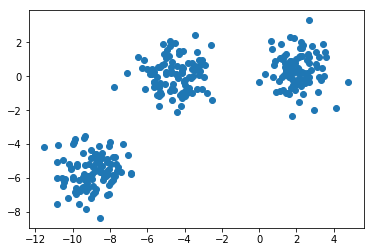

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_filtered = np.vstack((X[y == 0][:100], X[y == 1][:100], X[y == 2][:100]))
plt.scatter(X_filtered[:, 0], X_filtered[:, 1])
plt.show()

In [61]:
data = X_filtered
data.shape

(300, 2)

### Test run

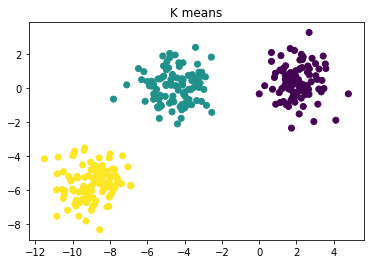

In [62]:
result = k_means(data,n_clusters=3,n_init=50,verbose=False,kernel=None)
y_pred = result['best_cluster_label']
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("K means")
plt.show()

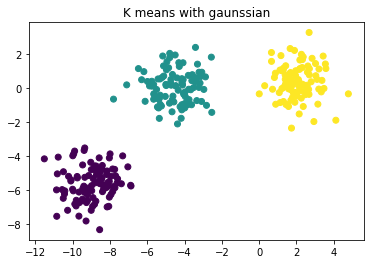

In [63]:
result = k_means(data,n_clusters=3,n_init=50,verbose=False,kernel='gaussian')
y_pred = result['best_cluster_label']
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("K means with gaunssian")
plt.show()

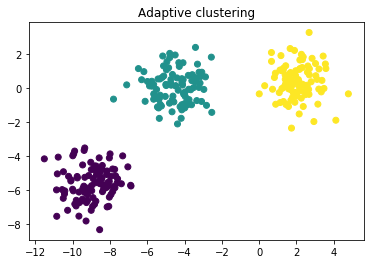

In [64]:
result = adaptive_cluster(data, gap_par = 0.5, debug=False)
y_pred = result['cluster_label']
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Adaptive clustering")
plt.show()

### Find best lambda

In [65]:
S_array = []
gap_pars = np.linspace(0.1,5,num=10)
for gap_par in gap_pars:
    result = adaptive_cluster(data, gap_par = gap_par, debug=False)
    S = result['S']
    print(gap_par,S)
    S_array.append(S)

0.1 27552
0.644444444444 30000
1.18888888889 30000
1.73333333333 30000
2.27777777778 30000
2.82222222222 30000
3.36666666667 30000
3.91111111111 30000
4.45555555556 30000
5.0 30000


## Load real data

In [68]:
##Aggregation.txt  Compound.txt  D31.txt  flame.txt  jain.txt  pathbased.txt  R15.txt  spiral.txt
cluster_data = {}

In [70]:
cluster_data['Aggregation'] = pd.read_csv('../data/Aggregation.txt',sep='\t',header=None)
cluster_data['Aggregation'].head()

,0,1,2
0,15.55,28.65,2
1,14.90,27.55,2
2,14.45,28.35,2
3,14.15,28.80,2
4,13.75,28.05,2
